## __Importing required frameworks__

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from mxnet.gluon.data import vision
from matplotlib import pyplot as plt
import os

plt.style.use('seaborn')

ctx = mx.gpu()

## __Doing data augmentation and defining data loaders__

In [0]:
train_transform = vision.transforms.Compose([vision.transforms.RandomSaturation(saturation = 0.1),
                                             vision.transforms.RandomLighting(alpha = 0.2),
                                             vision.transforms.RandomHue(hue = 0.1),
                                             vision.transforms.RandomFlipLeftRight(),
                                             vision.transforms.RandomContrast(contrast = 0.2),
                                             vision.transforms.RandomColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),                                            
                                             vision.transforms.ToTensor()])

transform = vision.transforms.Compose([vision.transforms.ToTensor()])

train_cifar = gluon.data.vision.CIFAR10(train = True).transform_first(train_transform)
test_cifar = gluon.data.vision.CIFAR10(train = False).transform_first(transform)

In [0]:
batch_size = 64
train_data = gluon.data.DataLoader(train_cifar, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(test_cifar, batch_size = batch_size, shuffle = False)

In [4]:
for features, labels in train_data:
    break

print(f"features.shape: {features.shape}")
print(f"labels.shape: {labels.shape}")

print(f"features.max(): {features.max().asscalar()}")
print(f"features.min(): {features.min().asscalar()}")

features.shape: (64, 3, 32, 32)
labels.shape: (64,)
features.max(): 1.0
features.min(): 0.0


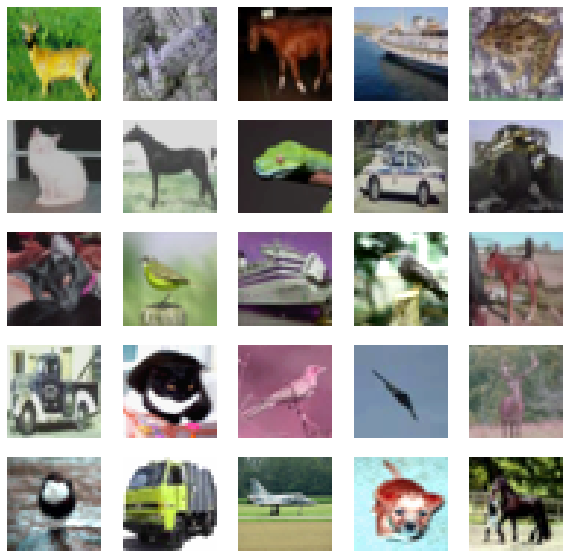

In [5]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(features[i].transpose((1, 2, 0)).asnumpy())
    plt.axis("off")
plt.show()

## __Defining model architecture__

Here we will use basic blocks of DenseNet and ResNet together!

In [0]:
class DenseBlock(nn.HybridBlock):
    def __init__(self, convs, channels):
        super(DenseBlock, self).__init__()

        self.model = nn.HybridSequential()
        for _ in range(convs):
            conv = nn.HybridSequential()
            conv.add(nn.BatchNorm())
            conv.add(nn.LeakyReLU(0.4))
            conv.add(nn.Conv2D(channels, kernel_size = 3, padding = 1))
            self.model.add(conv)

    def hybrid_forward(self, F, x):
        for layer in self.model:
            output = layer(x)
            x = F.concat(x, output, dim = 1)
        return x

class TransitionBlock(nn.HybridBlock):
    def __init__(self, channels):
        super(TransitionBlock, self).__init__()

        self.model = nn.HybridSequential()
        self.model.add(nn.BatchNorm())
        self.model.add(nn.Conv2D(channels, kernel_size = 1))
        self.model.add(nn.AvgPool2D(pool_size = 1, strides = 2))

    def hybrid_forward(self, F, x):
        return self.model(x)

class ResidualBlock(nn.HybridBlock):
    def __init__(self, channels, strides):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.HybridSequential()
        self.conv1.add(nn.Conv2D(channels, kernel_size = 3, padding = 1, strides = strides))
        self.conv1.add(nn.BatchNorm())
        self.conv1.add(nn.Activation('relu'))

        self.conv2 = nn.HybridSequential()
        self.conv2.add(nn.Conv2D(channels, kernel_size = 3, padding = 1))
        self.conv2.add(nn.BatchNorm())

        self.residual = nn.Conv2D(channels, kernel_size = 1, strides = strides)
        # doing network in network convolution(1X1) above for residual connection

        self.activation = nn.Activation('relu')

    def hybrid_forward(self, F, x):
        layer = self.conv1(x)
        layer = self.conv2(layer)
        residual = self.residual(x)
        return self.activation(layer + residual)

In [9]:
model = nn.HybridSequential()

model.add(nn.Dropout(0.3))
model.add(nn.Conv2D(32, kernel_size = 3, strides = 1, padding = 1))
model.add(nn.BatchNorm())
model.add(nn.LeakyReLU(0.4))
model.add(nn.MaxPool2D(pool_size = 2, strides = 1, padding = 1))

model.add(nn.Conv2D(64, kernel_size = 3, strides = 1, padding = 1))
model.add(nn.BatchNorm())
model.add(nn.LeakyReLU(0.4))

channels, growth = 64, 32
convs = [4, 4, 8, 8]

for i, num_convs in enumerate(convs):
    model.add(DenseBlock(num_convs, growth))
    channels += num_convs * growth
    if i != len(convs) - 1:
        channels //= 2
        model.add(TransitionBlock(channels))
        model.add(ResidualBlock(channels, strides = 1))

model.add(nn.BatchNorm())
model.add(nn.LeakyReLU(0.4))
model.add(nn.GlobalAvgPool2D())
model.add(nn.Dropout(0.5))
model.add(nn.Dense(20))

model.initialize(mx.init.Xavier(), ctx)
model

HybridSequential(
  (0): Dropout(p = 0.3, axes=())
  (1): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (3): LeakyReLU(0.4)
  (4): MaxPool2D(size=(2, 2), stride=(1, 1), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (5): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (7): LeakyReLU(0.4)
  (8): DenseBlock(
    (model): HybridSequential(
      (0): HybridSequential(
        (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
        (1): LeakyReLU(0.4)
        (2): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): HybridSequential(
        (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=

## __Visualizing model architecture__

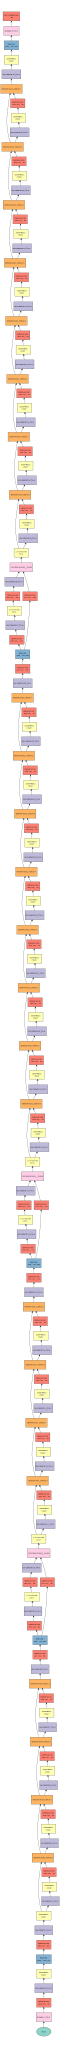

In [10]:
mx.viz.plot_network(model(mx.sym.var(name = 'data')), node_attrs = {'fixedsize': 'false'},)

## __Summarizing model layers__

In [11]:
model.summary(features.as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                             (64, 3, 32, 32)               0
           Dropout-1                             (64, 3, 32, 32)               0
            Conv2D-2                            (64, 32, 32, 32)             896
         BatchNorm-3                            (64, 32, 32, 32)             128
         LeakyReLU-4                            (64, 32, 32, 32)               0
         MaxPool2D-5                            (64, 32, 33, 33)               0
            Conv2D-6                            (64, 64, 33, 33)           18496
         BatchNorm-7                            (64, 64, 33, 33)             256
         LeakyReLU-8                            (64, 64, 33, 33)               0
         BatchNorm-9                            (64, 64, 33, 33)             256
        LeakyReLU-10        

## __Hybridizing and defining objective loss and optimizer__

In [0]:
model.hybridize()
objective = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.optimizer.Adam(learning_rate = 0.0008)
trainer = gluon.Trainer(model.collect_params(), optimizer)
top1 = mx.metric.Accuracy()
top3 = mx.metric.TopKAccuracy(top_k = 3)

## __Training the model__

In [15]:
epochs = 20
batches = len(train_data)

train_losses = []
top1_accs = []
top3_accs = []

for epoch in range(epochs):
    top1.reset()
    top3.reset()
    cum_loss = 0.0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        top1.update(labels, outputs)
        top3.update(labels, outputs)

    train_loss = cum_loss.asscalar()/batches
    top1_acc = top1.get()[1]
    top3_acc = top3.get()[1]

    train_losses.append(train_loss)
    top1_accs.append(top1_acc)
    top3_accs.append(top3_acc)
    
    print(f'Epoch: {epoch + 1} | Training Loss: {train_loss:.5f} | Top 1 Accuracy: {top1_acc:.5f} | Top 3 Accuracy: {top3_acc:.5f}')

Training Loss: 1.60924 | Top 1 Accuracy:   0.41856 | Top 3 Accuracy:   0.75148
Training Loss: 1.18658 | Top 1 Accuracy:   0.57742 | Top 3 Accuracy:   0.86096
Training Loss: 0.98032 | Top 1 Accuracy:   0.65410 | Top 3 Accuracy:   0.90070
Training Loss: 0.85610 | Top 1 Accuracy:   0.70004 | Top 3 Accuracy:   0.92070
Training Loss: 0.77053 | Top 1 Accuracy:   0.73072 | Top 3 Accuracy:   0.93324
Training Loss: 0.70941 | Top 1 Accuracy:   0.75430 | Top 3 Accuracy:   0.94222
Training Loss: 0.65304 | Top 1 Accuracy:   0.77220 | Top 3 Accuracy:   0.94822
Training Loss: 0.61131 | Top 1 Accuracy:   0.78796 | Top 3 Accuracy:   0.95334
Training Loss: 0.57996 | Top 1 Accuracy:   0.79828 | Top 3 Accuracy:   0.95710
Training Loss: 0.54559 | Top 1 Accuracy:   0.81052 | Top 3 Accuracy:   0.96146
Training Loss: 0.51031 | Top 1 Accuracy:   0.82298 | Top 3 Accuracy:   0.96584
Training Loss: 0.48409 | Top 1 Accuracy:   0.83190 | Top 3 Accuracy:   0.96982
Training Loss: 0.45375 | Top 1 Accuracy:   0.84444 |

## __Visualizing model improvement throughout training__

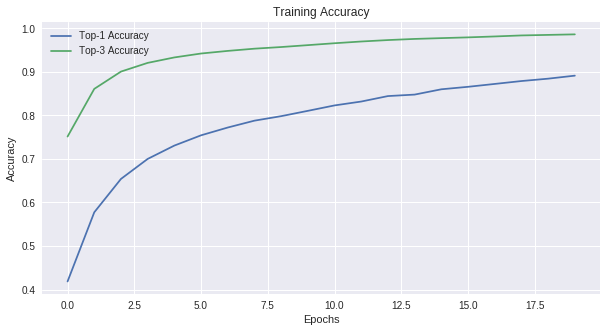

In [16]:
plt.figure(figsize = (10, 5))
plt.plot(top1_accs, label = 'Top-1 Accuracy')
plt.plot(top3_accs, label = 'Top-3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

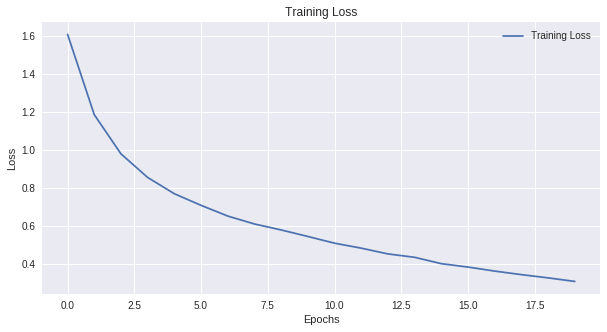

In [17]:
plt.figure(figsize = (10, 5))
plt.plot(train_losses, label = 'Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## __Testing the model__

In [18]:
top1.reset()
top3.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    top1.update(labels, outputs)
    top3.update(labels, outputs)
print(f'Testing Top-1 Accuracy: {top1.get()[1]}')
print(f'Testing Top-3 Accuracy: {top3.get()[1]}')

Testing Top-1 Accuracy: 0.793
Testing Top-3 Accuracy: 0.9528
